In [261]:
import bclr
import ruptures as rpt
import numpy as np
from ruptures.metrics import randindex
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import multivariate_normal, binom
import matplotlib.pyplot as plt
import pandas as pd
import changeforest
from sklearn.linear_model import LogisticRegression, LinearRegression
from ecp import e_divisive

from scipy.special import comb
from scipy.stats import median_abs_deviation as mad
from sklearn.metrics import adjusted_rand_score

pf = PolynomialFeatures(include_bias=False)
ss = StandardScaler()

In [327]:
def kcp_slhr(signal, Dmax = 100, div_med = True, gamma=0.02, alpha=2):
    "Implements slope heuristic of Arlot, Celisse, and Harchaoui (2019)"
    mads = mad(np.abs(np.diff(signal, axis=0)), axis=0)
    if div_med:
        signal = signal/mads
    
    kcp_obj = rpt.KernelCPD(kernel='rbf', params={'gamma': gamma})
    cost_obj = rpt.costs.CostRbf(gamma=gamma)

    kcp_obj.fit(signal)
    cost_obj.fit(signal)
    
    Dlow = int(0.6*Dmax)
    y = []
    n = len(signal)
    for k in range(1, Dmax+1):
        bkps_k = kcp_obj.predict(n_bkps=k)
        y.append(cost_obj.sum_of_costs(bkps_k))
    
    x1 = np.log(comb(np.repeat(n-1, Dmax), np.arange(1, Dmax+1)-1))/n
    x2 = np.arange(1, Dmax+1)/n
    X = np.c_[x1, x2]
    lrs = LinearRegression()
    lrs.fit(X[(Dlow-1):,:], y[(Dlow-1):])
    pen = (X @ np.expand_dims(-alpha*lrs.coef_, axis=1))[:,0]
    ncps = np.argmin(y + pen)
    return kcp_obj.predict(n_bkps=ncps+1)


Multiple changepoint demo

In [368]:
np.random.seed(191293)
n, dim = 1000, 5 # number of samples, dimension
n_bkps, sigma = 10, 3 # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

In [369]:
prior_cov=np.diag(np.repeat(10, 5))
rng = np.random.default_rng(199239)
bclrM = bclr.MultiBayesCC(signal, cps=20, prior_cov=prior_cov, min_size=10, rng=rng)
cps_df = bclrM.predict()

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [370]:
cps = cps_df['Location'].to_list() + [n]
randindex(cps, bkps)

1.0

### Correctly identifies the changes in each coordinate!!!

In [307]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM.bccs_]

[array([0.542, 0.768, 0.78 , 0.46 , 0.126, 0.928, 0.3  , 0.91 , 0.92 ,
        0.864, 0.926, 0.864, 0.854, 0.876, 0.146, 0.908, 0.654, 0.17 ,
        0.744, 0.166]),
 array([0.284, 0.766, 0.878, 0.892, 0.834, 0.898, 0.764, 0.156, 0.894,
        0.87 , 0.896, 0.908, 0.754, 0.256, 0.604, 0.622, 0.914, 0.802,
        0.88 , 0.882]),
 array([0.802, 0.542, 0.596, 0.116, 0.352, 0.886, 0.744, 0.524, 0.144,
        0.072, 0.668, 0.984, 0.106, 0.048, 0.066, 0.152, 0.176, 0.05 ,
        0.226, 0.032]),
 array([0.066, 0.928, 0.164, 0.152, 0.278, 0.086, 0.074, 0.68 , 0.934,
        0.236, 0.924, 0.756, 0.096, 0.294, 0.114, 0.484, 0.866, 0.066,
        0.452, 0.246]),
 array([0.922, 0.168, 0.154, 0.918, 0.084, 0.06 , 0.864, 0.584, 0.238,
        0.17 , 0.394, 0.766, 0.952, 0.714, 0.056, 0.116, 0.198, 0.394,
        0.902, 0.128]),
 array([0.53 , 0.086, 0.21 , 0.748, 0.884, 0.856, 0.956, 0.604, 0.136,
        0.954, 0.102, 0.178, 0.302, 0.786, 0.132, 0.732, 0.072, 0.894,
        0.134, 0.936]),
 arr

In [308]:
[bc.post_beta_mean for bc in bclrM.bccs_]

[array([ 0.04285628,  0.25965786,  0.31934708, -0.03368663, -0.45971412,
         0.50527168, -0.17231063,  0.55381218,  0.56464163,  0.3747544 ,
         0.5896284 ,  0.40378793,  0.40243494,  0.4221535 , -0.41194137,
         0.54316387,  0.14263114, -0.36739531,  0.24279636, -0.37451043]),
 array([-0.21205914,  0.28447977,  0.49453249,  0.38695334,  0.37110396,
         0.49033095,  0.26688294, -0.41816814,  0.48062046,  0.39413704,
         0.54390906,  0.5033245 ,  0.23127901, -0.22797014,  0.11490761,
         0.12171266,  0.53749926,  0.32536783,  0.49163307,  0.45737383]),
 array([ 0.30070513,  0.02042758,  0.08953816, -0.48578175, -0.11820451,
         0.41199931,  0.21507855,  0.03477654, -0.36161415, -0.49934672,
         0.13649209,  0.73557918, -0.45566444, -0.62729994, -0.58380001,
        -0.37283586, -0.32857464, -0.65641   , -0.23868091, -0.64582281]),
 array([-0.58777152,  0.5444239 , -0.36428588, -0.38967863, -0.22286742,
        -0.48490151, -0.54375963,  0.13090693

In [10]:
bkps2 = [0]+bkps
for i in range(len(bkps2)-1):
    print(np.mean(signal[bkps2[i]:bkps2[i+1], :], axis=0))

[4.85896743 7.09654116 1.66628311]
[0.75197459 2.18377263 8.08471679]
[ 4.0136651  -6.08451579  3.02110253]
[ -2.11727663 -10.87766866  -6.32345238]
[ -8.85192302 -18.9546945    2.23322792]
[-16.41716849 -22.84898953   5.15605168]


### Other methods...

In [371]:
cps_cf = changeforest.changeforest(signal).split_points() + [n]
randindex(cps_cf, bkps)

0.9977177177177177

In [372]:
cps_kcp = kcp_slhr(signal)
randindex(cps_kcp, bkps)

0.9996476476476477

## What if we looked at changes of differing nature?

In [412]:
np.random.seed(881910)
h1 = np.array([[1, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
h2 = np.array([[4, 0.4, 0.1], [0.4, 1, 0], [0.1, 0, 1]])
h3 = np.array([[4, 0.4, -1.7], [0.4, 1, 0], [-1.7, 0, 1]])
L1 = np.linalg.cholesky(h1)
L2 = np.linalg.cholesky(h2)
L3 = np.linalg.cholesky(h3)

a = np.random.randn(100, 3) @ L1
b = np.random.randn(75, 3) @ L2
c = np.random.randn(30, 3) @ L2 + np.broadcast_to([0, 3, 0], (30, 3))
d = np.random.randn(45, 3) @ L3 + np.broadcast_to([0, 3, 0], (45, 3))

X = np.r_[a,b,c,d]
Xnew = ss.fit_transform(pf.fit_transform(np.r_[a,b,c,d]))
prior_cov9 = np.diag(np.repeat(1, 9))

In [413]:
bclrM_new = bclr.MultiBayesCC(Xnew, cps=10, prior_cov=prior_cov9, min_size=10)
cps=bclrM_new.predict()

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [414]:
def seg_to_lab(cps):
    K = len(cps)
    vals = [np.repeat(0, cps[0])] + [np.repeat(i, cps[i]-cps[i-1]) for i in range(1, K)]
    return np.concatenate(vals, axis=0)

def adj_rand(bkps, bkps_true):
    bkp_lab = seg_to_lab(bkps)
    bkp_labt = seg_to_lab(bkps_true)
    return adjusted_rand_score(bkp_lab, bkp_labt)

In [415]:
cps

,Location,Posterior Probability,Normalized Entropy
0,77.0,0.132,0.813001
1,110.0,0.160,0.686257
2,176.0,0.512,0.160480


In [416]:
changes = [100, 175, 205, 250]

In [417]:
cps_bclr = cps['Location'].to_list()+[250]
adj_rand(cps_bclr, changes)

0.6778042959427207

In [418]:
randindex(cps_bclr, changes)

0.8698795180722891

### Now we can summarize the output of our algorithm...

In [419]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM_new.bccs_]

[array([0.33 , 0.73 , 0.64 , 0.702, 0.356, 0.202, 0.508, 0.68 , 0.292]),
 array([0.726, 0.126, 0.234, 0.926, 0.754, 0.606, 0.008, 0.284, 0.31 ]),
 array([0.212, 1.   , 0.536, 0.562, 0.532, 0.382, 0.986, 0.368, 0.076])]

In [420]:
cf_res = changeforest.changeforest(Xnew).split_points()+[250]
print(cf_res)
print(randindex(cf_res, changes))

adj_rand(cf_res, changes)

[176, 206, 250]
0.7501365461847389


0.5158915047861785

In [425]:
cf_ecp = e_divisive.e_divisive(Xnew)['estimates'][1:]
adj_rand(cf_ecp, changes)

0.45756639696854023

In [424]:
cf_kcp = kcp_slhr(Xnew)
adj_rand(cf_kcp, changes)

0.45756639696854023

### Central England temperature series

In [427]:
import re
f = open("mean_temps_central_england.txt", "r")
lines = [re.sub(r"\n", "", re.sub(r"[ ]+", " ", a)).split(" ") for a in f.readlines()]

In [428]:
mtu = pd.DataFrame([l[1:] for l in lines[5:]], columns=lines[4][1:])
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)

In [485]:
prior_cov1 = np.diag(np.repeat(1,1))
ncps = 7
bclrM_cet = bclr.MultiBayesCC(Xcet, cps=ncps, prior_cov=prior_cov1, min_size=10, n_iter=5000)
df_dis = bclrM_cet.predict(iter_sch = [300, 500], thr_sch = [0.9, 0.7], offset=1658)

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [487]:
print(df_dis.sort_values(by=['Posterior Probability'], ascending=False))

   Location  Posterior Probability  Normalized Entropy
2    1987.0                 0.4372            0.299850
0    1701.0                 0.0868            0.651271
1    1892.0                 0.0620            0.705620


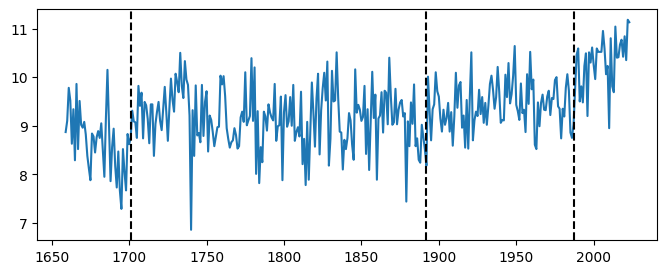

In [488]:
plt.figure(figsize=(8, 3))
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)
years = mtu[['Year']][:-1].to_numpy(dtype=np.double)
plt.plot(years[:], Xcet[:])
[plt.axvline(df_dis['Location'].iloc[i], color='black', linestyle='--') for i in range(len(df_dis))]

In [494]:
np.array(kcp_slhr(Xcet)[:-1])+1658

array([1690, 1698, 1726, 1738, 1892, 1988])

In [493]:
op = changeforest.changeforest(Xcet)
np.array(op.split_points())+1658

array([1982, 1988])